# Projet MADMC

In [58]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [11]:
def readInstance(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    n = int(allLines[2].split(" ")[1])

    objects = np.empty((n, 3))
    for i, line in enumerate(allLines[4:4+n]):
        objects[i] = list( map(int, line.rstrip().lstrip("i ").split("\t")) )

    W = int(allLines[-2].split(" ")[1])

    return objects, W

In [12]:
def readNotDominatedPoints(path):

    with open(path, 'r') as f:
        allLines = f.readlines()

    allPoints = []
    for line in allLines:
        allPoints.append( list(map(int, line.rstrip().split("\t"))) )

    return np.array(allPoints)

In [13]:
def proportionNotDominated(nd_points, potential_nd_points):
    nd_points_set = set(list(map(tuple, nd_points)))
    potential_nd_points_set = set(list(map(tuple, potential_nd_points)))
    
    return len(nd_points_set & potential_nd_points_set)/len(nd_points)

In [14]:
def averageDistance(nd_points, potential_nd_points):
    nadir_pt = np.array((nd_points[:, 0].min(), nd_points[:, 1].min()))
    print(nadir_pt)
    ideal_pt = np.array((nd_points[:, 0].max(), nd_points[:, 1].max()))
    p1 = 1/(ideal_pt[0]-nadir_pt[0])
    p2 = 1/(ideal_pt[1]-nadir_pt[1])
    
    distances = []
    
    for i, nd_point in enumerate(nd_points):
        euclidian_dist = math.inf
        for potential_nd_point in potential_nd_points:
            euclidian_dist_tmp =  math.sqrt(p1*(potential_nd_point[0]-nd_point[0])**2 + p2*(potential_nd_point[1]-nd_point[1])**2)
            
            if(euclidian_dist_tmp < euclidian_dist):
                euclidian_dist = euclidian_dist_tmp
    
        distances.append(euclidian_dist)
    
    distances = np.array(distances)
    
    return (1/len(nd_points))*distances.sum()


In [15]:
def solutionTotalWeight(solution, objects):
    sum = 0
    for i, sol in enumerate(solution):
        if(sol == 1):
            sum += objects[:,0][i]
    return sum

In [42]:
def generatePop(objects, max_weight):
    solution = np.random.randint(2, size=len(objects))
    sumWeights = 0
    freeObjectsIndexes = []
    
    for i in range(0, len(solution)):
        if(solution[i] == 1):
            sumWeights += objects[:,0][i]
        else:
            freeObjectsIndexes.append(i)

        #make sure that the solution respects max weight
        if(sumWeights > max_weight):
            solution[i] = 0
            sumWeights -= objects[:,0][i]
            freeObjectsIndexes.append(i)
    
    #add random objects to fill the bag
    while(sumWeights < max_weight and len(freeObjectsIndexes) > 0):
        i = random.randint(0, len(freeObjectsIndexes)-1)
        if(sumWeights + objects[:,0][freeObjectsIndexes[i]] < max_weight):
            solution[freeObjectsIndexes[i]] = 1
            sumWeights += objects[:,0][freeObjectsIndexes[i]]
            #print("add ", objects[:,0][freeObjectsIndexes[i]], sumWeights)
        del freeObjectsIndexes[i]
            
    #print("current weight : ", sumWeights, " max weight : ", max_weight)
    
    
    return solution

In [110]:
def neighborhood(solution, objects, max_weight):
    solutionSum = solution.sum()
    neighborhoodPop = []
    
    #if there is at least one object selected and still some other(s) not selected
    if(solutionSum >= 1 and solutionSum < len(objects)):
        totalWeight = solutionTotalWeight(solution, objects)
        newTotalWeight = totalWeight
        neighbor_sol = solution.copy()
        permutationDone = False
        
        #sort objects in two lists (of indexes) wether they are in backpack or not
        availableObjects = []
        takenObjects = []
        for i in range(0, len(neighbor_sol)-1):
            if(neighbor_sol[i] == 0):
                availableObjects.append(i)
            else:
                takenObjects.append(i)
                
        for i in range(len(takenObjects)):
            takenObjectIndex = takenObjects[i]

            for j in range(len(availableObjects)):
                availableObjectIndex = availableObjects[j]

                newTotalWeight = totalWeight - objects[:,0][takenObjectIndex] + objects[:,0][availableObjectIndex]

                #permutation only if valid solution
                if(newTotalWeight > max_weight):
                    break
                else:
                    neighbor_sol = solution.copy()
                    totalWeight = newTotalWeight
                    permutationDone = True
                    neighbor_sol[takenObjectIndex] = 0
                    neighbor_sol[availableObjectIndex] = 1
                    
                    availableObjectsTmp = availableObjects.copy()
                    availableObjectsTmp.append(availableObjectIndex)
                    del availableObjectsTmp[j] #no need to del for takenObjects (list not used after)
                    #print("replaced index", takenObjectIndex, "with", availableObjectIndex)


                    #new spaces filled with objects if possible
                    new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                    availableObjectIndex = availableObjectsTmp[new_object_index]

                    while(totalWeight < max_weight and len(availableObjectsTmp) > 0):
                        if(totalWeight+objects[:,0][availableObjectIndex] <= max_weight):
                            neighbor_sol[availableObjectIndex] = 1
                            totalWeight += objects[:,0][availableObjectIndex]

                        del availableObjectsTmp[new_object_index]

                        if(len(availableObjectsTmp) > 0): #verification for the last loop
                            new_object_index = random.randint(0, len(availableObjectsTmp)-1)
                            availableObjectIndex = availableObjectsTmp[new_object_index]
                    
                    neighborhoodPop.append(neighbor_sol)
                    
        #print("aa",neighborhoodPop,"bb", neighborhoodPop[0])
        return neighborhoodPop

In [19]:
def evaluateSolution(solution, earnings):
    earnings_values = [0]*(earnings[0].size)
    
    for i in range(earnings[0].size): #for each objective
        for j in range(earnings[:, i].size-1): #the valuation for each object
            earnings_values[i] += solution[j]*earnings[:, i][j] #solution[j] = 1 or 0
    return earnings_values

In [20]:
def isDominated(sol1, sol2, earnings):
    earnings_sol1 = evaluateSolution(sol1, earnings)
    earnings_sol2 = evaluateSolution(sol2, earnings)
    if earnings_sol1[0] < earnings_sol2[0]:
        return earnings_sol1[1] <= earnings_sol2[1]
    return False

In [108]:
def update(solutionsSet, solutionToReview, objects, earnings):
    for solution in solutionsSet:
        if(isDominated(solutionToReview, solution, earnings)):
            return False
        
    #another loop to not remove element if solutionToReview is dominated
    """for i in range(len(solutionsSet):
        if(isDominated(solutionsSet[i], solutionToReview, earnings)):
            #print(solutionsSet,"\n")
            solutionsSet.remove(solutionsSet[i])"""
    
    solutionsSet.append(solutionToReview)
    return True

In [32]:
def plot_objective_space(points, points2):
    x, y = [i[0] for i in points], [j[1] for j in points]
    x2, y2 = [int(i[0]) for i in points2], [int(j[1]) for j in points2]
    plt.scatter(x, y, c='red')
    plt.scatter(x2, y2, c='blue')
    plt.show()

In [51]:
def localParetoSearch1(objects, capacity, non_dominated_points=[]):
    earnings = objects[:, 1:]

    #objects = objects[objects[:, 0].argsort()]

    #random_sol, solution_alea = generatePop(objects, capacity)
    random_sol = generatePop(objects, capacity)

    #valid, evalP = evaluateSolution(solution_alea, objects, capacity)
    evalP = evaluateSolution(random_sol, earnings)
    
    # initialisation d'un ens. de sol. efficaces  et d'une population
    population = []
    efficient_solutions = []
    efficient_solutions.append(random_sol)
    population.append(np.array(random_sol))
    k = 0
    ez = [evalP]
    # initialisation d'une pop. auxiliaire
    auxiliar_population = []
    evalBase = []
    while(len(population) > 0):
        k += 1
        j = 0

        #print(population)
        # génération de tous les voisins de chaque solution appartenant à population
        nghbhood, evals = [], []
        for p in population:
            print(str((j)/len(population)*100) + '%')

            j += 1

            #valid, evalBase = evaluate_solution(p, objects, capacity)
            evalBase = evaluateSolution(p, earnings)


            #voisinage, evals = voisinage1_1(p, objects, capacity)
            nghbhood = neighborhood(p, objects, capacity)
            
            #while not voisinage:
            #voisinage, evals = voisinage1_1(p, objects, capacity)

            #for voisin, eval in zip(voisinage, evals):
            for neighbor in nghbhood:
                #print('nouvelleeval')
                #print(eval)
                # si p_prime n'est pas dominé par p:

                #if not dominated(eval, evalBase):
                if not isDominated(neighbor, p, earnings):

                    if update(auxiliar_population, neighbor, objects, earnings):
                        update(efficient_solutions, neighbor, objects, earnings)
                        
            nghbhood, evals = [], []
            
            
        if len(efficient_solutions) > 10:
            ez = [evaluateSolution(r, earnings) for r in efficient_solutions]
            print(ez)
            plot_objective_space(ez, non_dominated_points)

        population = auxiliar_population
        auxiliar_population = []
        #print('efficient solutions=Evaluations')
        print('taille du front efficace')
        print(np.array(efficient_solutions).shape)

    return efficient_solutions


In [103]:
a = []
b = np.array([4,5,6])
a.append(b)
a.remove(b)
print(a)

[]


**-------------TEST METHODES-------------**

In [22]:
(objects, weight) = readInstance("InstancesMOKP/100_items/2KP100-TA-0.dat")
nd_points = readNotDominatedPoints("InstancesMOKP/100_items/2KP100-TA-0.eff")
print(objects, "\n max weight :", weight)

[[394. 783. 840.]
 [911. 198. 798.]
 [768. 278. 335.]
 [477. 629. 554.]
 [513. 952. 365.]
 [636. 717. 916.]
 [607.  17. 142.]
 [138. 804. 243.]
 [401. 130. 157.]
 [998. 219. 109.]
 [839. 613. 513.]
 [637. 524. 296.]
 [972. 293. 494.]
 [527. 770. 771.]
 [891. 284. 400.]
 [807. 919. 353.]
 [949. 526.  70.]
 [193. 663.  86.]
 [349.  65. 890.]
 [458.  64.  21.]
 [970. 902. 239.]
 [267. 540. 851.]
 [760. 513. 375.]
 [532.  40. 668.]
 [931. 930. 438.]
 [285. 738. 721.]
 [354. 688. 640.]
 [440. 880. 166.]
 [331. 229. 829.]
 [351. 686. 893.]
 [589. 657. 956.]
 [440. 924. 858.]
 [814. 684. 399.]
 [483. 216. 911.]
 [920. 148. 950.]
 [641. 432. 881.]
 [281. 786. 619.]
 [447. 226. 308.]
 [276. 556. 188.]
 [170. 906. 417.]
 [126. 495. 104.]
 [984. 935. 760.]
 [383. 750. 684.]
 [294. 233. 369.]
 [245. 153. 584.]
 [126. 793. 732.]
 [745.  75. 164.]
 [ 53. 522. 950.]
 [240. 798. 177.]
 [656. 967. 732.]
 [759.  94. 639.]
 [520.  79. 135.]
 [205. 461.  70.]
 [573. 755. 819.]
 [158. 999.  52.]
 [890. 126

In [23]:
#earnings for each objective
earnings = objects[:,1:]
print(earnings[:, 1].size-1)

99


In [73]:
#print(nd_points)
#nd_points = np.hsplit(nd_points, 2)
#print(nd_points)
#plot.plot(nd_points[:,0], nd_points[:,1])

In [31]:
generatedPop = generatePop(objects, weight)
print(generatedPop, solutionTotalWeight(generatedPop, objects), len(neighborhood(generatedPop, objects, weight)))

current weight :  26825.0  max weight :  26856
[0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0
 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0
 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1] 26825.0 151


In [102]:
evaluateSolution(generatedPop, earnings)

1
2
0
1
[28033.0, 27763.0]


[28033.0, 27763.0]

In [25]:
neighbor = neighborhood(generatedPop, objects, weight)
print(neighbor, solutionTotalWeight(neighbor, objects))

exchanged 94 and 65
[0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1
 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0] 26854.0


0.0%
taille du front efficace
(10, 100)
0.0%
11.11111111111111%
22.22222222222222%
33.33333333333333%
44.44444444444444%
55.55555555555556%
66.66666666666666%
77.77777777777779%
88.88888888888889%
[[27513.0, 29153.0], [28867.0, 29913.0], [29292.0, 30847.0], [28903.0, 30904.0], [30069.0, 30886.0], [30498.0, 30677.0], [28554.0, 31327.0], [29275.0, 31293.0], [30704.0, 31483.0], [31309.0, 30773.0], [31189.0, 31584.0], [31287.0, 31506.0], [31966.0, 31680.0], [29574.0, 31734.0], [30981.0, 31873.0], [30821.0, 31887.0], [30073.0, 32281.0], [30753.0, 33406.0], [31090.0, 31859.0], [31373.0, 33549.0], [31515.0, 31943.0], [31429.0, 31968.0], [31501.0, 32867.0], [31717.0, 33368.0], [31842.0, 32115.0], [32191.0, 32573.0], [32037.0, 32897.0], [31761.0, 32910.0], [32214.0, 31667.0], [32216.0, 31708.0], [32226.0, 33077.0], [32248.0, 31465.0], [32314.0, 32468.0], [32539.0, 32010.0], [32827.0, 33211.0], [32902.0, 32333.0], [32537.0, 33437.0], [33278.0, 32812.0], [31606.0, 33522.0], [31900.0, 33445.0], [3

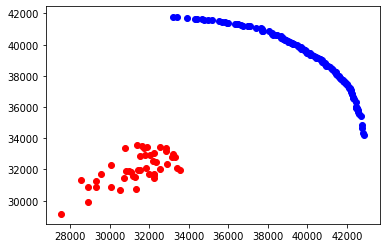

taille du front efficace
(45, 100)
0.0%
2.7027027027027026%
5.405405405405405%
8.108108108108109%
10.81081081081081%
13.513513513513514%
16.216216216216218%
18.91891891891892%
21.62162162162162%
24.324324324324326%
27.027027027027028%
29.72972972972973%
32.432432432432435%
35.13513513513514%
37.83783783783784%
40.54054054054054%
43.24324324324324%
45.94594594594595%
48.64864864864865%
51.35135135135135%
54.054054054054056%
56.75675675675676%
59.45945945945946%
62.16216216216216%
64.86486486486487%
67.56756756756756%
70.27027027027027%
72.97297297297297%
75.67567567567568%
78.37837837837837%
81.08108108108108%
83.78378378378379%
86.48648648648648%
89.1891891891892%
91.8918918918919%
94.5945945945946%
97.2972972972973%
[[27513.0, 29153.0], [28867.0, 29913.0], [29292.0, 30847.0], [28903.0, 30904.0], [30069.0, 30886.0], [30498.0, 30677.0], [28554.0, 31327.0], [29275.0, 31293.0], [30704.0, 31483.0], [31309.0, 30773.0], [31189.0, 31584.0], [31287.0, 31506.0], [31966.0, 31680.0], [29574.0, 31

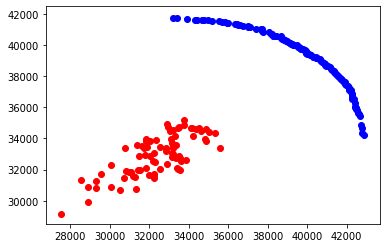

taille du front efficace
(85, 100)
0.0%
1.36986301369863%
2.73972602739726%
4.10958904109589%
5.47945205479452%
6.8493150684931505%
8.21917808219178%
9.58904109589041%
10.95890410958904%
12.32876712328767%
13.698630136986301%
15.068493150684931%
16.43835616438356%
17.80821917808219%
19.17808219178082%
20.54794520547945%
21.91780821917808%
23.28767123287671%
24.65753424657534%
26.027397260273972%
27.397260273972602%
28.767123287671232%
30.136986301369863%
31.506849315068493%
32.87671232876712%
34.24657534246575%
35.61643835616438%
36.986301369863014%
38.35616438356164%
39.726027397260275%
41.0958904109589%
42.465753424657535%
43.83561643835616%
45.20547945205479%
46.57534246575342%
47.94520547945205%
49.31506849315068%
50.68493150684932%
52.054794520547944%
53.42465753424658%
54.794520547945204%
56.16438356164384%
57.534246575342465%
58.9041095890411%
60.273972602739725%
61.64383561643836%
63.013698630136986%
64.38356164383562%
65.75342465753424%
67.12328767123287%
68.4931506849315%
69.

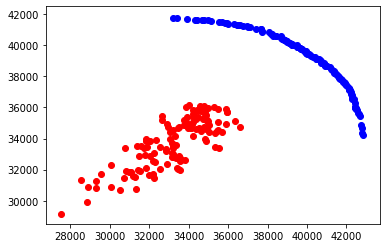

taille du front efficace
(131, 100)
0.0%
0.8333333333333334%
1.6666666666666667%
2.5%
3.3333333333333335%
4.166666666666666%
5.0%
5.833333333333333%
6.666666666666667%
7.5%
8.333333333333332%
9.166666666666666%
10.0%
10.833333333333334%
11.666666666666666%
12.5%
13.333333333333334%
14.166666666666666%
15.0%
15.833333333333332%
16.666666666666664%
17.5%
18.333333333333332%
19.166666666666668%
20.0%
20.833333333333336%
21.666666666666668%
22.5%
23.333333333333332%
24.166666666666668%
25.0%
25.833333333333336%
26.666666666666668%
27.500000000000004%
28.333333333333332%
29.166666666666668%
30.0%
30.833333333333336%
31.666666666666664%
32.5%
33.33333333333333%
34.166666666666664%
35.0%
35.833333333333336%
36.666666666666664%
37.5%
38.333333333333336%
39.166666666666664%
40.0%
40.833333333333336%
41.66666666666667%
42.5%
43.333333333333336%
44.166666666666664%
45.0%
45.83333333333333%
46.666666666666664%
47.5%
48.333333333333336%
49.166666666666664%
50.0%
50.83333333333333%
51.66666666666667

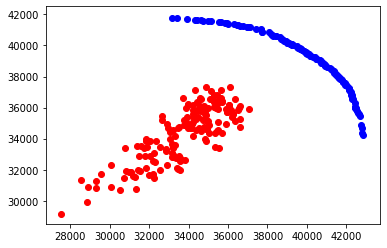

taille du front efficace
(168, 100)
0.0%
0.6535947712418301%
1.3071895424836601%
1.9607843137254901%
2.6143790849673203%
3.2679738562091507%
3.9215686274509802%
4.57516339869281%
5.228758169934641%
5.88235294117647%
6.535947712418301%
7.18954248366013%
7.8431372549019605%
8.49673202614379%
9.15032679738562%
9.803921568627452%
10.457516339869281%
11.11111111111111%
11.76470588235294%
12.418300653594772%
13.071895424836603%
13.725490196078432%
14.37908496732026%
15.032679738562091%
15.686274509803921%


In [ ]:
localParetoSearch1(objects, weight, nd_points)